## Face Detection Algorithms Comparison ##

Using Contrast Limited Adaptive Histogram Equalization 

In [1]:
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import time
import dlib
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from facenet_pytorch import MTCNN
from PIL import Image, ImageDraw

2023-09-21 17:16:18.019202: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-21 17:16:18.020561: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-21 17:16:18.053341: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-21 17:16:18.053882: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-21 17:16:18.587895: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
root_dir = "/home/daniel/testing"
dest_dir_ssd = "/home/daniel/testingSSD"
dest_dir_haar = "/home/daniel/testingHAAR"
dest_dir_dlib = "/home/daniel/testingDLIB"
dest_dir_mp = "/home/daniel/testingMP"
dest_dir_mtcnn = "/home/daniel/testingMTCNN"

## Single Shot Multibox Detector ##

In [3]:
prototxtPath= os.path.join("deploy.prototxt.txt")
caffemodelPath =  os.path.join("res10_300x300_ssd_iter_140000.caffemodel")
detector = cv2.dnn.readNet(prototxtPath, caffemodelPath)

In [4]:
start = time.time()

image_initial = cv2.imread('testing/frame_1942.png',  cv2.IMREAD_COLOR)
image_array = cv2.cvtColor(image_initial, cv2.COLOR_BGR2GRAY)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
final_img = clahe.apply(image_array)

image_array = cv2.cvtColor(final_img, cv2.COLOR_GRAY2BGR)

print("Total time CLAHE: ", (time.time() - start) * 1000, "milliseconds")  

original_size = image_array.shape
target_size = (300, 300)

resized_array = cv2.resize(image_array , target_size)
img = image_array.copy()

aspect_ratio_x = (original_size[1] / target_size[1])
aspect_ratio_y = (original_size[0] / target_size[0])

imageBlob = cv2.dnn.blobFromImage(image= resized_array)

detector.setInput(imageBlob)

detections = detector.forward()

detections_df = pd.DataFrame(detections[0][0], columns = ["img_id", "is_face", "confidence", "left", "top", "right", "bottom"])

detections_df = detections_df[detections_df['is_face'] == 1]
detections_df = detections_df[detections_df['confidence'] >= 0.90]

for i, instance in detections_df.iterrows():

    left = int(instance["left"] * 300)
    bottom = int(instance["bottom"] * 300)
    right = int(instance["right"] * 300)
    top = int(instance["top"] * 300)

    detected_face = img[int(top*aspect_ratio_y):int(bottom*aspect_ratio_y), int(left*aspect_ratio_x):int(right*aspect_ratio_x)].copy()

print("Total time: ", (time.time() - start) * 1000, "milliseconds")

Total time CLAHE:  6.726980209350586 milliseconds
Total time:  61.35869026184082 milliseconds


Face Detected
Confidence:  99.77%
shape (192, 192, 3)


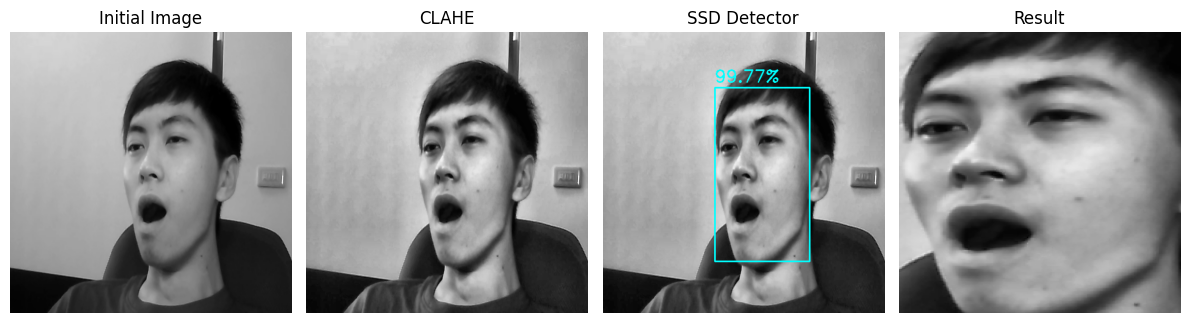

In [5]:
if detected_face.shape[0] > 0 and detected_face.shape[1] > 0:
        confidence_score = str(round(100*instance["confidence"], 2))+"%"
        cv2.putText(img, confidence_score, (int(left*aspect_ratio_x), int(top*aspect_ratio_y-10)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,255), 2)
        cv2.rectangle(img, (int(left*aspect_ratio_x), int(top*aspect_ratio_y)), (int(right*aspect_ratio_x), int(bottom*aspect_ratio_y)), (0,255,255), 2) 

if i == 0:
    print("Face Detected")
else:
    print("Face Not Detected")
    
print("Confidence: ", confidence_score)
detected_face = cv2.resize(detected_face, (192, 192))
print("shape", detected_face.shape)


fig, axs = plt.subplots(1,4)
axs[0].imshow(image_initial)
axs[0].axis('off')
axs[0].set_title("Initial Image")
axs[1].imshow(image_array)
axs[1].axis('off')
axs[1].set_title("CLAHE")
axs[2].imshow(img)
axs[2].axis('off')
axs[2].set_title("SSD Detector")
axs[3].imshow(detected_face)
axs[3].axis('off')
axs[3].set_title("Result")

fig.set_figwidth(12)
plt.tight_layout()
plt.show()

In [6]:
start = time.time()

for images in os.listdir(root_dir):
    image_path = os.path.join(root_dir, images)
    image_initial = cv2.imread(image_path,  cv2.IMREAD_COLOR)
    image_array = cv2.cvtColor(image_initial, cv2.COLOR_BGR2GRAY)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    final_img = clahe.apply(image_array)

    image_array = cv2.cvtColor(final_img, cv2.COLOR_GRAY2BGR)

    original_size = image_array.shape
    target_size = (300, 300)

    resized_array = cv2.resize(image_array , target_size)

    aspect_ratio_x = (original_size[1] / target_size[1])
    aspect_ratio_y = (original_size[0] / target_size[0])

    imageBlob = cv2.dnn.blobFromImage(image= resized_array)

    detector.setInput(imageBlob)

    detections = detector.forward()

    detections_df = pd.DataFrame(detections[0][0], columns = ["img_id", "is_face", "confidence", "left", "top", "right", "bottom"])

    detections_df = detections_df[detections_df['is_face'] == 1]
    detections_df = detections_df[detections_df['confidence'] >= 0.90]

    for i, instance in detections_df.iterrows():

        left = int(instance["left"] * 300)
        bottom = int(instance["bottom"] * 300)
        right = int(instance["right"] * 300)
        top = int(instance["top"] * 300)

        detected_face = image_array[int(top*aspect_ratio_y):int(bottom*aspect_ratio_y), int(left*aspect_ratio_x):int(right*aspect_ratio_x)].copy()
        output_path = os.path.join(dest_dir_ssd, images)

        cv2.imwrite(output_path, detected_face)


total_time = (time.time() - start) * 1000
total_per_frame = total_time/3000
fps = 1000/total_per_frame
detection_rate = (len(os.listdir(dest_dir_ssd))/3000) * 100 

print("Total time: ", total_time, "milliseconds")
print("Total time per frame: ", total_per_frame, "milliseconds")
print("Frames per second: ", fps)
print("Total Detection Rate: ", detection_rate, " %")

Total time:  57449.650287628174 milliseconds
Total time per frame:  19.149883429209392 milliseconds
Frames per second:  52.219639022694835
Total Detection Rate:  80.5  %


## DLIB Frontal Face Detector HOG + SVM ##

In [7]:
face_detector = dlib.get_frontal_face_detector()

In [8]:
start = time.time()

image_initial = cv2.imread('testing/frame_1942.png',  cv2.IMREAD_COLOR)
image_array = cv2.cvtColor(image_initial, cv2.COLOR_BGR2GRAY)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
final_img = clahe.apply(image_array)

image_array = cv2.cvtColor(final_img, cv2.COLOR_GRAY2BGR)
img = image_array.copy()

print("Total time CLAHE: ", (time.time() - start) * 1000, "milliseconds")  

faces = face_detector(img,1)
for (i, rect) in enumerate(faces):
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

detected_face = img[y:h+y,x:w+x].copy()

print("Total time: ", (time.time() - start) * 1000, "milliseconds")         

Total time CLAHE:  4.752159118652344 milliseconds
Total time:  111.81831359863281 milliseconds


Confidence:  95.88%
shape (192, 192, 3)


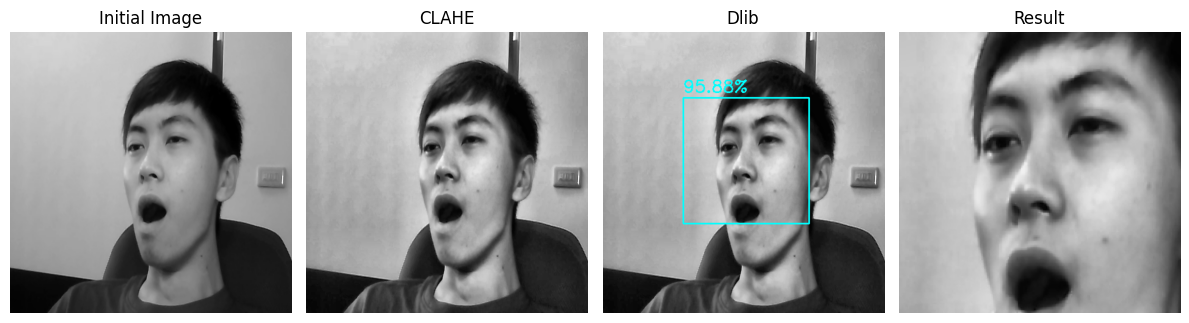

In [9]:
_, scores, _ = face_detector.run(img, 1)
confidence_score = str(round(100*scores[0], 2))+"%"
cv2.putText(img, confidence_score, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,255), 2)

cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 255), 2)

detected_face = cv2.resize(detected_face, (192, 192))
print("Confidence: ", confidence_score)
print("shape", detected_face.shape)

fig, axs = plt.subplots(1,4)
axs[0].imshow(image_initial)
axs[0].axis('off')
axs[0].set_title("Initial Image")
axs[1].imshow(image_array)
axs[1].axis('off')
axs[1].set_title("CLAHE")
axs[2].imshow(img)
axs[2].axis('off')
axs[2].set_title("Dlib")
axs[3].imshow(detected_face)
axs[3].axis('off')
axs[3].set_title("Result")

fig.set_figwidth(12)
plt.tight_layout()
plt.show()

In [10]:
start = time.time()

for images in os.listdir(root_dir):
    detected_face = None
    image_path = os.path.join(root_dir, images)
    image_initial = cv2.imread(image_path,  cv2.IMREAD_COLOR)
    image_array = cv2.cvtColor(image_initial, cv2.COLOR_BGR2GRAY)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    final_img = clahe.apply(image_array)

    image_array = cv2.cvtColor(final_img, cv2.COLOR_GRAY2BGR)

    faces = face_detector(image_array,1)
    
    for (i, rect) in enumerate(faces):
        x = rect.left()
        y = rect.top()
        w = rect.right() - x
        h = rect.bottom() - y
        detected_face = image_array[y:h+y,x:w+x].copy()

    output_path = os.path.join(dest_dir_dlib, images)

    if detected_face is not None and detected_face.size>0:
        cv2.imwrite(output_path, detected_face)


total_time = (time.time() - start) * 1000
total_per_frame = total_time/3000
fps = 1000/total_per_frame
detection_rate = (len(os.listdir(dest_dir_dlib))/3000) * 100 

print("Total time: ", total_time, "milliseconds")
print("Total time per frame: ", total_per_frame, "milliseconds")
print("Frames per second: ", fps)
print("Total Detection Rate: ", detection_rate, " %")

Total time:  73897.81737327576 milliseconds
Total time per frame:  24.63260579109192 milliseconds
Frames per second:  40.596598203249684
Total Detection Rate:  65.3  %


## Haar Cascade Classifier ##

In [11]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [12]:
start = time.time()

image_initial = cv2.imread('testing/frame_1942.png')
image_array = cv2.cvtColor(image_initial, cv2.COLOR_BGR2GRAY)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
final_img = clahe.apply(image_array)

image_array = cv2.cvtColor(final_img, cv2.COLOR_GRAY2BGR)
img = image_array.copy()

print("Total time CLAHE: ", (time.time() - start) * 1000, "milliseconds") 

faces = face_cascade.detectMultiScale(img)

for (x, y, w, h) in faces:
    
    detected_face = img[y:y+h, x:x+w].copy()

print("Total time: ", (time.time() - start) * 1000, "milliseconds")     

Total time CLAHE:  5.1364898681640625 milliseconds
Total time:  31.20279312133789 milliseconds


shape (192, 192, 3)


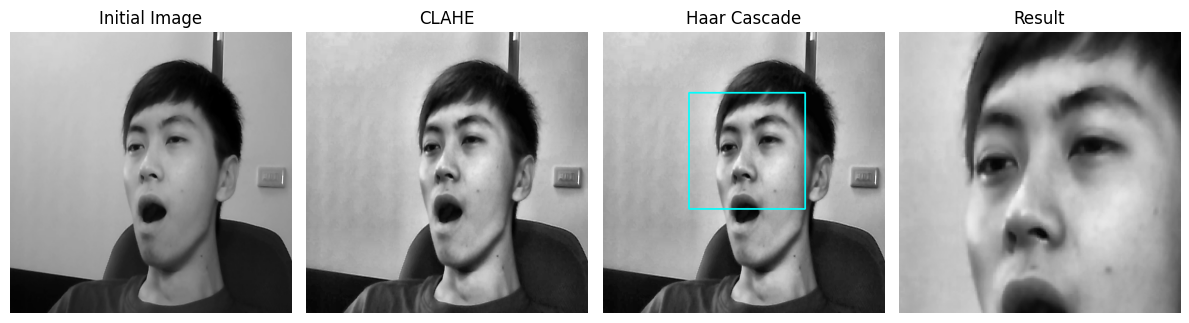

In [13]:
cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 255), 2)
detected_face = cv2.resize(detected_face, (192, 192))
print("shape", detected_face.shape)

fig, axs = plt.subplots(1,4)
axs[0].imshow(image_initial)
axs[0].axis('off')
axs[0].set_title("Initial Image")
axs[1].imshow(image_array)
axs[1].axis('off')
axs[1].set_title("CLAHE")
axs[2].imshow(img)
axs[2].axis('off')
axs[2].set_title("Haar Cascade")
axs[3].imshow(detected_face)
axs[3].axis('off')
axs[3].set_title("Result")

fig.set_figwidth(12)
plt.tight_layout()
plt.show()

In [14]:
start = time.time()

for images in os.listdir(root_dir):
    detected_face = None
    image_path = os.path.join(root_dir, images)
    image_initial = cv2.imread(image_path,  cv2.IMREAD_COLOR)
    image_array = cv2.cvtColor(image_initial, cv2.COLOR_BGR2GRAY)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    final_img = clahe.apply(image_array)

    image_array = cv2.cvtColor(final_img, cv2.COLOR_GRAY2BGR)

    faces = face_cascade.detectMultiScale(image_array)

    for (x, y, w, h) in faces:
    
        detected_face = image_array[y:y+h, x:x+w].copy()
        
    output_path = os.path.join(dest_dir_haar, images)

    if detected_face is not None and detected_face.size>0:
        cv2.imwrite(output_path, detected_face)


total_time = (time.time() - start) * 1000
total_per_frame = total_time/3000
fps = 1000/total_per_frame
detection_rate = (len(os.listdir(dest_dir_haar))/3000) * 100 

print("Total time: ", total_time, "milliseconds")
print("Total time per frame: ", total_per_frame, "milliseconds")
print("Frames per second: ", fps)
print("Total Detection Rate: ", detection_rate, " %")

Total time:  32377.21872329712 milliseconds
Total time per frame:  10.79240624109904 milliseconds
Frames per second:  92.65774264425443
Total Detection Rate:  68.83333333333333  %


## Mediapipe Face Detector ##

In [15]:
base_options = python.BaseOptions(model_asset_path='detector.tflite')
options = vision.FaceDetectorOptions(base_options=base_options)
detector = vision.FaceDetector.create_from_options(options)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [16]:
start = time.time()

image_initial = cv2.imread('testing/frame_1942.png')
image_array = cv2.cvtColor(image_initial, cv2.COLOR_BGR2GRAY)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
final_img = clahe.apply(image_array)

image_array = cv2.cvtColor(final_img, cv2.COLOR_GRAY2BGR)

print("Total time CLAHE: ", (time.time() - start) * 1000, "milliseconds")  

img = image_array.copy()
image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_array)

detection_result = detector.detect(image)

for detection in detection_result.detections:

    bbox = detection.bounding_box
    detected_face = img[int(bbox.origin_y):int(bbox.origin_y + bbox.height), int(bbox.origin_x):int(bbox.origin_x + bbox.width)].copy()
    

print("Total time: ", (time.time() - start) * 1000, "milliseconds")


Total time CLAHE:  5.214691162109375 milliseconds
Total time:  9.57036018371582 milliseconds


Confidence:  81.62%
shape (192, 192, 3)


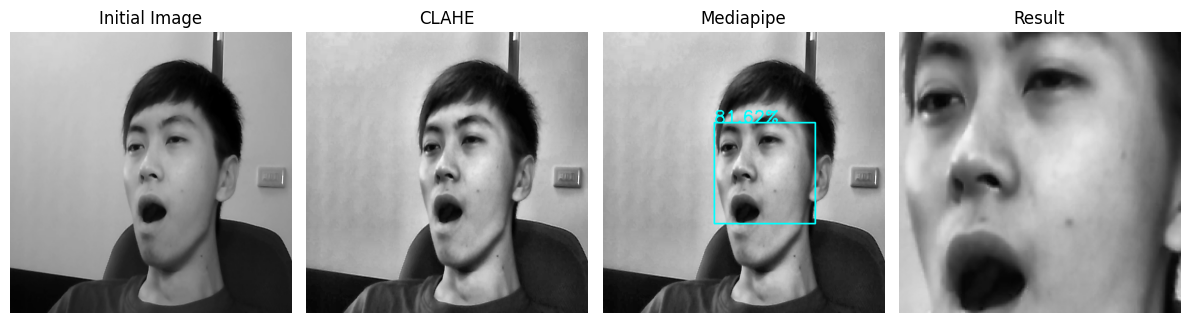

In [17]:
cv2.rectangle(img, (bbox.origin_x, bbox.origin_y), (bbox.origin_x + bbox.width, bbox.origin_y + bbox.height), (0, 255, 255), 2)
category = detection.categories[0]
confidence_score = str(round(100*category.score, 2))+"%"
cv2.putText(img, confidence_score, (bbox.origin_x, bbox.origin_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

detected_face = cv2.resize(detected_face, (192, 192))
print("Confidence: ", confidence_score)
print("shape", detected_face.shape)

fig, axs = plt.subplots(1,4)
axs[0].imshow(image_initial)
axs[0].axis('off')
axs[0].set_title("Initial Image")
axs[1].imshow(image_array)
axs[1].axis('off')
axs[1].set_title("CLAHE")
axs[2].imshow(img)
axs[2].axis('off')
axs[2].set_title("Mediapipe")
axs[3].imshow(detected_face)
axs[3].axis('off')
axs[3].set_title("Result")

fig.set_figwidth(12)
plt.tight_layout()
plt.show()

In [18]:
start = time.time()

for images in os.listdir(root_dir):
    
    detected_face = None
    image_path = os.path.join(root_dir, images)
    image_initial = cv2.imread(image_path,  cv2.IMREAD_COLOR)
    image_array = cv2.cvtColor(image_initial, cv2.COLOR_BGR2GRAY)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    final_img = clahe.apply(image_array)

    image_array = cv2.cvtColor(final_img, cv2.COLOR_GRAY2BGR)

    image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_array)

    detection_result = detector.detect(image)

    for detection in detection_result.detections:

        bbox = detection.bounding_box
        detected_face = image_array[int(bbox.origin_y):int(bbox.origin_y + bbox.height), int(bbox.origin_x):int(bbox.origin_x + bbox.width)].copy()
    
    output_path = os.path.join(dest_dir_mp, images)

    if detected_face is not None and detected_face.size>0:
        cv2.imwrite(output_path, detected_face)


total_time = (time.time() - start) * 1000
total_per_frame = total_time/3000
fps = 1000/total_per_frame
detection_rate = (len(os.listdir(dest_dir_mp))/3000) * 100 

print("Total time: ", total_time, "milliseconds")
print("Total time per frame: ", total_per_frame, "milliseconds")
print("Frames per second: ", fps)
print("Total Detection Rate: ", detection_rate, " %")

Total time:  9982.604265213013 milliseconds
Total time per frame:  3.3275347550710044 milliseconds
Frames per second:  300.5227814603732
Total Detection Rate:  97.76666666666667  %


## MTCNN Detector ##

In [19]:
mtcnn = MTCNN(select_largest=False)

In [20]:
start = time.time()

image_initial = cv2.imread('testing/frame_1942.png')
image_array = cv2.cvtColor(image_initial, cv2.COLOR_BGR2GRAY)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
final_img = clahe.apply(image_array)

image_array = cv2.cvtColor(final_img, cv2.COLOR_GRAY2RGB)

print("Total time CLAHE: ", (time.time() - start) * 1000, "milliseconds")  

img = Image.fromarray(image_array)

boxes, probs = mtcnn.detect(img)
draw = ImageDraw.Draw(img)

for box in boxes:
    rectangle = box.tolist()
    detected_face = img.crop(rectangle)

print("Total time: ", (time.time() - start) * 1000, "milliseconds")

Total time CLAHE:  6.79779052734375 milliseconds
Total time:  61.86699867248535 milliseconds


Confidence:  99.57%
(192, 192)


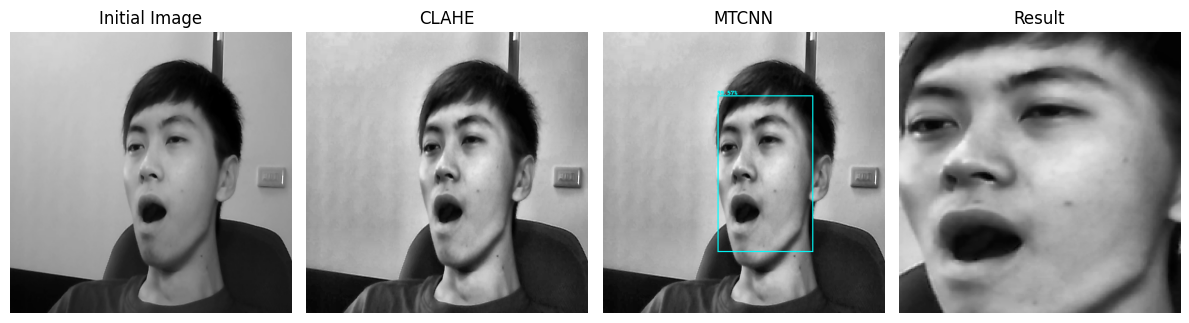

In [21]:
confidence_score = str(round(100*probs[0], 2))+"%"
draw.text((rectangle[0], rectangle[1]-10), confidence_score, (0, 255, 255))
draw.rectangle(rectangle, outline=(0, 255, 255), width=2)
detected_face = detected_face.resize((192, 192))
print("Confidence: ", confidence_score)
print(detected_face.size)

fig, axs = plt.subplots(1,4)
axs[0].imshow(image_initial)
axs[0].axis('off')
axs[0].set_title("Initial Image")
axs[1].imshow(image_array)
axs[1].axis('off')
axs[1].set_title("CLAHE")
axs[2].imshow(img)
axs[2].axis('off')
axs[2].set_title("MTCNN")
axs[3].imshow(detected_face)
axs[3].axis('off')
axs[3].set_title("Result")

fig.set_figwidth(12)
plt.tight_layout()
plt.show()

In [22]:
start = time.time()

for images in os.listdir(root_dir):
    detected_face = None
    image_path = os.path.join(root_dir, images)
    image_initial = cv2.imread(image_path,  cv2.IMREAD_COLOR)
    image_array = cv2.cvtColor(image_initial, cv2.COLOR_BGR2GRAY)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    final_img = clahe.apply(image_array)

    image_array = cv2.cvtColor(final_img, cv2.COLOR_GRAY2BGR)

    img = Image.fromarray(image_array)

    boxes, probs = mtcnn.detect(img)

    if boxes is None:
        continue
    
    for box in boxes:
        rectangle = box.tolist()
        detected_face = img.crop(rectangle)
    
    output_path = os.path.join(dest_dir_mtcnn, images)
    
    if detected_face is not None:
        detected_face.save(output_path)


total_time = (time.time() - start) * 1000
total_per_frame = total_time/3000
fps = 1000/total_per_frame
detection_rate = (len(os.listdir(dest_dir_mtcnn))/3000) * 100 

print("Total time: ", total_time, "milliseconds")
print("Total time per frame: ", total_per_frame, "milliseconds")
print("Frames per second: ", fps)
print("Total Detection Rate: ", detection_rate, " %")

Total time:  56343.47939491272 milliseconds
Total time per frame:  18.78115979830424 milliseconds
Frames per second:  53.24484806791806
Total Detection Rate:  77.93333333333334  %
